In [1]:
import numpy as np
import random
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import time

In [2]:
def schaffer_function(mat_x_y):
    x = mat_x_y[:, 0]
    y = mat_x_y[:, 1]
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

In [3]:
def neighbors_matrix(arr, n_neighbors):
    n = len(arr)
    if n < 3:
        raise ValueError("Array length must be at least 3")
    arr_circular = np.concatenate((arr[n-n_neighbors+1:], arr, arr[:n_neighbors]))
    print(arr_circular)
    shape = (n, n_neighbors)
    strides = arr_circular.strides * 2
    return np.lib.stride_tricks.as_strided(arr_circular, shape=shape, strides=strides)
arr = np.array([1, 2, 3, 4, 5])
matrix = neighbors_matrix(arr, 2)
matrix


[5 1 2 3 4 5 1 2]


array([[5, 1],
       [1, 2],
       [2, 3],
       [3, 4],
       [4, 5]])

100%|██████████| 10000/10000 [00:00<00:00, 14900.82it/s]


--- 0.6727747917175293 seconds ---


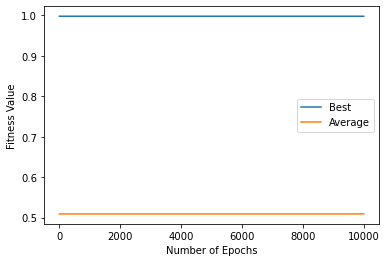

In [40]:
class PSO():
    def __init__(self,
                 num_epochs:int,
                 pop_size:int,
                 chrom_length:int,
                 n_best:int,
                 local_factor:float,
                 global_factor:float,
                 speed_factor:float,
                 v_max: float,
                 value_ranges:list,
                 fitness_func, # Function Type,
                 seed=42,
                 eval_every=100,
                 verbose = 0,
                ):
        
        self.num_epochs = num_epochs
        self.pop_size = pop_size
        self.n_best = n_best
        self.chrom_length = chrom_length
        self.local_factor = local_factor
        self.global_factor = global_factor
        self.speed_factor = speed_factor
        self.v_max = v_max
        self.value_ranges = np.array(value_ranges)
        self.fitness_func = fitness_func
        self.seed = seed    
        self.best_ind_list = np.zeros(self.num_epochs)
        self.avg_ind_list = np.zeros(self.num_epochs)
        self.eval_every = eval_every
        self.verbose = verbose
        np.random.seed(seed=seed)


        self.init_pop()
        self.get_global_best()
        self.get_local_best_space()
        #self.update_speed()
        #self.update_position()

        print

    def init_pop(self):
        """
        Initializes a matrix with random values from an uniform distribution
        """
        self.x_i = np.random.rand(self.pop_size, self.chrom_length)
        self.v_i = np.random.rand(self.pop_size, self.chrom_length)
        self.v_i = self.v_i * (2 * self.v_max) - self.v_max
        # Denormalization process
        min_mat = self.value_ranges.T[0, :]
        max_mat = self.value_ranges.T[1,:]
        self.x_i = self.x_i * (max_mat - min_mat) + min_mat
        self.f_i = self.fitness_func(self.x_i)
        return

    def get_global_best(self):
        self.f_g_best = self.f_i.max()
        self.g_best = self.x_i[self.f_g_best == self.f_i]
        return
    
    def neighbors_matrix(self, arr, n_neighbors):
        n = len(arr)
        if n < 3:
            raise ValueError(f"Array length must be at least {n}")
        arr_circular = np.concatenate((arr[n:], arr, arr[:n_neighbors]))
        shape = (n, n_neighbors)
        strides = arr_circular.strides * 2
        return np.lib.stride_tricks.as_strided(arr_circular, shape=shape, strides=strides)

    def bottom_n_indexes(self, matrix, n):
        # Get the indices of the n largest elements in each row of the matrix
        largest_n_indices = np.argsort(matrix, axis=1)[:, :n]
        
        # Return the indices in descending order (i.e., the largest indices first)
        return np.flip(largest_n_indices, axis=1)

    
    def get_local_best(self):
        n_matrix = self.neighbors_matrix(self.f_i, self.n_best)
        self.f_l_best = n_matrix.max(axis=1)
        self.l_best_indices = np.where(self.f_i[:,None] == self.f_l_best[None,:])[0]
        self.l_best = self.x_i[self.l_best_indices]
        return
    
    def get_local_best_space(self):
        diffs = self.x_i[:, np.newaxis, :] - self.x_i[np.newaxis, :, :]
        squared_diffs = np.square(diffs)
        squared_distances = np.sum(squared_diffs, axis=-1)
        distances = np.sqrt(squared_distances)

        # Lowest indices are in the right side of the matrix. The last row is composed of a distance of 0 so we must discard it.
        bottom_n_indices = self.bottom_n_indexes(distances, self.n_best + 1)
        self.l_best_indices = bottom_n_indices[:,self.n_best - 1]
        self.l_best = self.x_i[self.l_best_indices]
        
    
    def update_speed(self):
        self.v_i_1 = self.speed_factor * self.v_i + \
            self.global_factor * (self.g_best - self.x_i) +\
            self.local_factor * (self.l_best - self.x_i)
        self.v_i_1[self.v_i_1 > self.v_max] = self.v_max
        self.v_i_1[self.v_i_1 < -self.v_max] = self.v_max
        return
    
    def update_position(self):
        self.x_i = self.x_i + self.v_i_1
        self.v_i = self.v_i_1
        return
    
    def callback(self):
        max_val = np.max(self.f_g_best)
        mean_val = np.mean(self.f_i)
        self.best_ind_list[self.curr_epoch] = max_val
        self.avg_ind_list[self.curr_epoch] = mean_val
        if (self.curr_epoch % self.eval_every == 0) and self.verbose != 0 :
            print(f"Epoch {self.curr_epoch}: Best: {max_val}, Average: {mean_val}")
    
    def fit(self):
        start_time = time.time()
        self.init_pop()
        for epoch in tqdm(range(self.num_epochs)):
            self.curr_epoch = epoch
            self.get_global_best()
            self.get_local_best()
            #self.get_local_best_space()
            self.update_speed()
            self.update_position()
            self.callback()
        print("--- %s seconds ---" % (time.time() - start_time))
        return self.x_i

    def plot(self):
        plt.plot(self.best_ind_list, label="Best")
        plt.plot(self.avg_ind_list, label="Average")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Fitness Value")
        plt.legend()
        plt.show()


pso_alg = PSO( 
                num_epochs=10000,
                pop_size=100,
                chrom_length=2,
                n_best=10,
                global_factor = 2,
                local_factor = 1,
                speed_factor = 0.8,
                v_max=0.2,
                value_ranges=[(-10,10), (-10,10)],
                fitness_func=schaffer_function

            )
best_solutions = pso_alg.fit()
pso_alg.plot()

Text(0.5, 0, 'z')

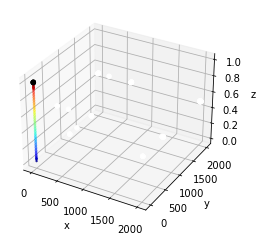

In [41]:
def schaffer_function_plot(x,y):
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

x_data = best_solutions[:, 0]
y_data = best_solutions[:, 1]
z_data = schaffer_function_plot(x_data, y_data)

x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)

X, Y = np.meshgrid(x, y)
Z = schaffer_function_plot(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='jet', alpha=0.2)
ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='binary', alpha=1)
#ax.set_xlim3d(-10,10)
#ax.set_ylim3d(-10,10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
